In [1]:
#importing useful libraries

import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import itertools
import matplotlib.colors as mcolors
import io
from PIL import Image
import gc
import os
import re
import json
import imageio
import time
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from scipy.ndimage import rotate
from scipy.optimize import minimize


In [2]:
#some  global variables

MAX_IMAGE_SIZE = 3000000 #this et the maximum number of pixels we authorize for an image
#this has to be lowered in case of GPUOutOfMemory error 


In [3]:
#some useful functions

def list_directory_contents(directory):
    """return a list of all directories and folder inside directory"""
    pictures_list = []

    try:
        with os.scandir(directory) as entries:
            for entry in entries:
                #print(entry.name)
                pictures_list.append(entry.name)
    except FileNotFoundError:
        print(f"The directory {directory} does not exist.")
    except NotADirectoryError:
        print(f"{directory} is not a directory.")
    except PermissionError:
        print(f"Permission denied to access {directory}.")
    return pictures_list

def list_files(startpath,exclude = "Vrac"):
    """From a stratpath this function list all files with full directory
    We allow to exclude one folder (can be easily adapted to several)"""
    file_list = []
    for root, dirs, files in os.walk(startpath):
        if not exclude in root:
            for file in files:
                file_list.append(os.path.join(root, file))
    return file_list



In [4]:
#loading SAM

model_type = "vit_l" #is hace more or less gpu memory, you can switch to less or more heavy models, see http://github.com/facebookresearch/segment-anything for more details and checkpoint download
sam = sam_model_registry[model_type](checkpoint = '/home/gabriel/Documents/TR DIMA/codes/sam_checkpoint/sam_vit_l_0b3195.pth') #put here the path to checkpoint
sam.cuda() #moving model to cuda

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

**Section 1 :** 
Image cropping $ \\ $
(you must restart the kernel each time you wan't to lauch the code of this section to avoid GPUoutofmemoryerror)
 $ \\ $
 You may have issues with GPU memory if you lauch the cell with sam.cuda() instruction several time during the same session

In [5]:
#creating AUtomaticMaskGenerator instance

mask_generator = SamAutomaticMaskGenerator(sam,min_mask_region_area=5000)

#the second parameter stand to avoid masks with several connected components with one of them to small to be a wing
#he might be ajusted if your dataset have very high quality or very low quality


In [6]:
#useful functions for section 1

def Find_bbox(mask):
    """return x_min,y_min,x_max,y_max for the mask"""
    mask = np.array(mask,dtype = np.uint8)
    mask_coords = np.argwhere(mask == 1)
    xmin,ymin,xmax,ymax = np.min(mask_coords[:,0]),np.min(mask_coords[:,1]),np.max(mask_coords[:,0]),np.max(mask_coords[:,1])
    return xmin,ymin,xmax,ymax

def Rotation_matrix(theta):

    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])


def Find_Optimal_Rotation(mask):

    mask = np.array(mask,dtype = np.uint8)

    where_array = np.argwhere(mask == 1)

    def objective_function(theta):
        R_m = Rotation_matrix(theta)
        rotated_mask_coordinates = np.dot(where_array,R_m)
        xmin,ymin,xmax,ymax = np.min(rotated_mask_coordinates[:,0]),np.min(rotated_mask_coordinates[:,1]),np.max(rotated_mask_coordinates[:,0]),np.max(rotated_mask_coordinates[:,1])
        width = ymax - ymin
        height = xmax - xmin
        return -width/height
    
    result = minimize(objective_function,x0 = 0.0,method='BFGS',tol = 0.0001)
    best_angle = np.squeeze(result.x,axis = 0)
    best_ratio = np.abs(result.fun)
    return best_angle,best_ratio

def Universal_crop_reshaper(wing_picture,wing_mask,red_factor,mode='crop',goal_shape = (256,512)):
    """return the reshape crop of wing with boundarie adjustment to fit goal_shape
     without any deformations """
    xmin_i,ymin_i,xmax_i,ymax_i = Find_bbox(wing_mask)
    x,y = goal_shape  

    ratio_ini = (ymax_i-ymin_i)/(xmax_i-xmin_i)
    ratio_f = y/x

    xir,yir,_ = wing_picture.shape

    if ratio_f > ratio_ini:
        ymin_f = int(max(0,(ymax_i+ymin_i)/2-ratio_f/ratio_ini*(ymax_i-ymin_i)/2))
        ymax_f = int(ymin_f + (ymax_i-ymin_i)*ratio_f/ratio_ini)
        xmin_f,xmax_f  = xmin_i,xmax_i
    else:
        xmin_f = int(max(0,(xmax_i+xmin_i)/2-ratio_ini/ratio_f*(xmax_i-xmin_i)/2))
        xmax_f = int(xmin_f + (xmax_i-xmin_i)*ratio_ini/ratio_f)
        ymin_f,ymax_f  = ymin_i,ymax_i

    xmin_f,xmax_f,ymin_f,ymax_f = int(xmin_f*red_factor),int(xmax_f*red_factor),int(ymin_f*red_factor),int(ymax_f*red_factor)
    
    if mode == 'crop':
        cropped_wing = wing_picture[xmin_f:xmax_f,ymin_f:ymax_f]
        resized_cropped_wing = cv2.resize(cropped_wing,(y,x),interpolation = cv2.INTER_LINEAR)
        return resized_cropped_wing, [xmin_f,xmax_f,ymin_f,ymax_f]
    
    elif mode == 'seg':
        extended_effective_mask = cv2.resize(wing_mask,(yir,xir),interpolation = cv2.INTER_LINEAR)
        extended_effective_mask = np.expand_dims(extended_effective_mask,axis = 2).astype(np.float32)
        segmented_cropped_wing = (wing_picture[xmin_f:xmax_f,ymin_f:ymax_f]*extended_effective_mask[xmin_f:xmax_f,ymin_f:ymax_f]).astype(np.uint8)
        resized_seg_wing = cv2.resize(segmented_cropped_wing,(y,x))
        return resized_seg_wing

def segment_and_crop(wing_image,option = 'C'):
    """this function take image with wing and white background
      as argument and return segmented and cropped wing as np array
      """
    gc.collect()
    torch.cuda.empty_cache()  #clear gpu memory (don' t know if it's really useful)
    
    xi,yi,zi = wing_image.shape
    reduction_factor = max(1,(xi*yi/MAX_IMAGE_SIZE)**(1/2)) 
    #the parameter above is necessary, because some images are too big, and this cause issues for SAM inference
    image_r = cv2.resize(wing_image, (int(yi/reduction_factor), int(xi/reduction_factor)),interpolation = cv2.INTER_LINEAR)

    # Generate masks
    with torch.no_grad():
        masks = mask_generator.generate(image_r) #generating masks

    current_max_area = 0   #this will store the current area of the object that verify the condition below : the goal is to extract the largest one that respect that condition
    wing_mask = None
    effective_best_rotation = 0 #in case something went wrong, we set default best rotation to 0
    effective_best_ratio = None

    #thanks to the parameters set for AutomaticMaskGenerator, we don't need a filter for largest connected component
    #we however have to compute the rotation that maximize width/height factor, to use this to discriminate masks
    #this will be then used to rotate wings
    


    for mask in masks:
        effective_mask = np.array(mask['segmentation'],dtype = np.uint8)
        best_rotation,best_ratio = Find_Optimal_Rotation(effective_mask)

        if 2.2<best_ratio<2.8: #parameters set empirically
            if mask['area'] > current_max_area:
                effective_best_rotation = best_rotation
                effective_best_ratio = best_ratio #this variable is never used
                wing_mask = mask
                current_max_area = mask['area'] #update current_max_area value


    effective_best_rotation = effective_best_rotation  * 180/np.pi #conversion to degree
    effective_mask = rotate(np.array(wing_mask['segmentation'],dtype = np.float32),angle=effective_best_rotation,reshape = True)
    effective_mask = np.round(effective_mask).astype(np.uint8)
   
    wing_image_rotated = rotate(wing_image,angle=effective_best_rotation,reshape = True)



    cropped_rotated_wing,bbox = Universal_crop_reshaper(wing_image_rotated,effective_mask,reduction_factor)
    segmented_rotated_wing = Universal_crop_reshaper(wing_image_rotated,effective_mask,reduction_factor,mode='seg')

    return cropped_rotated_wing,segmented_rotated_wing,effective_best_rotation,bbox






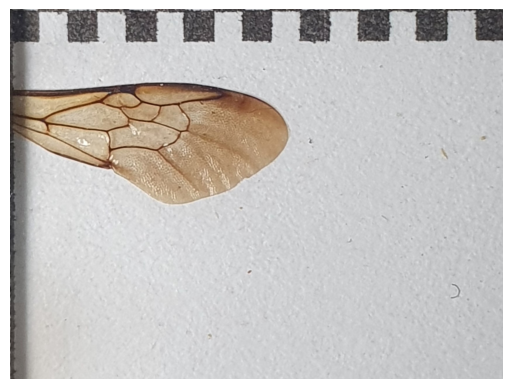

3.366460652816955
[289, 763, 29, 978]


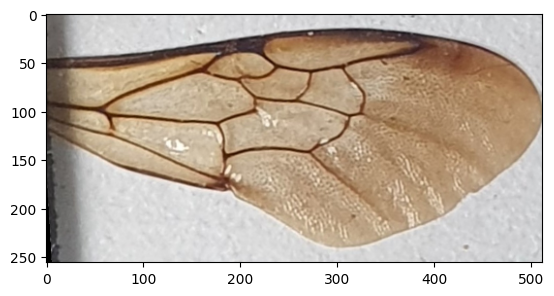

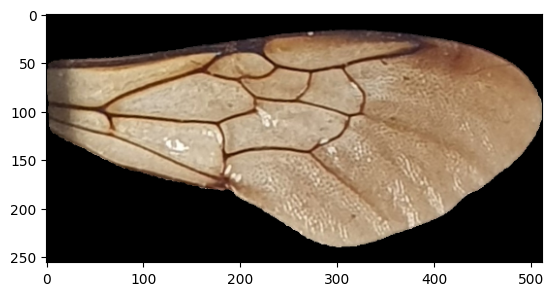

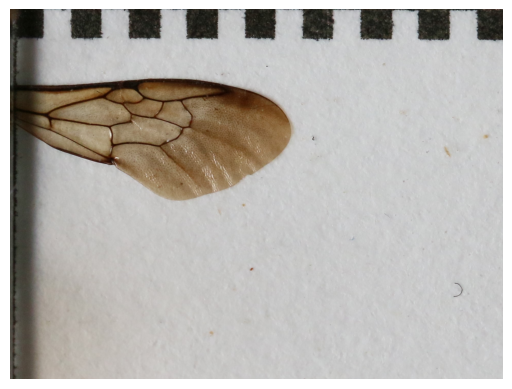

4.398704717446453
[335, 877, 47, 1131]


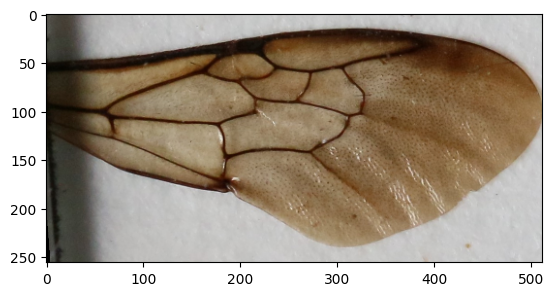

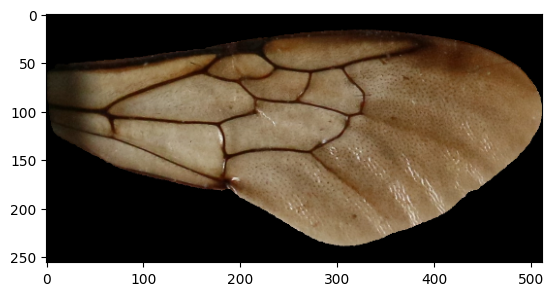

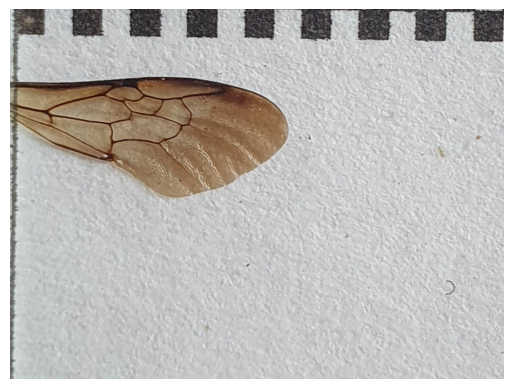

3.5763337212804736
[274, 755, 25, 987]


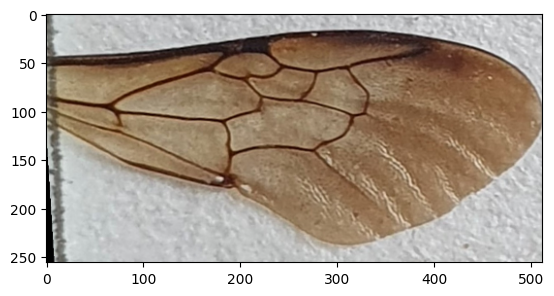

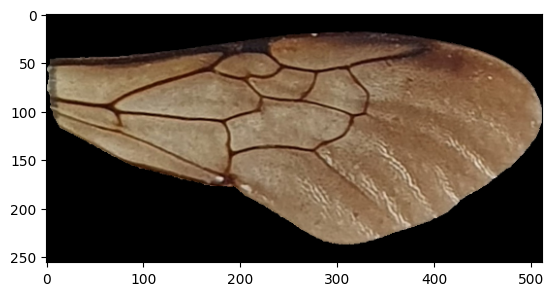

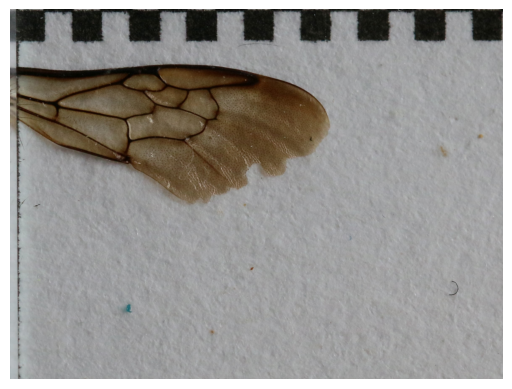

4.014175659236837
[321, 1068, 61, 1555]


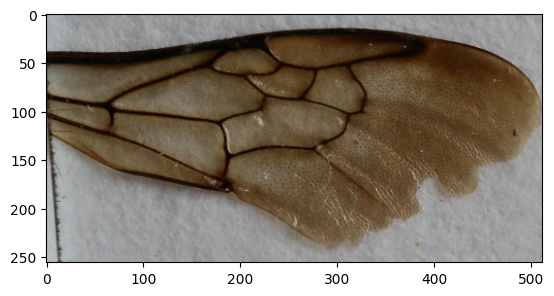

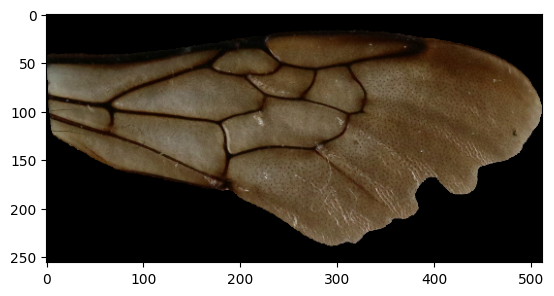

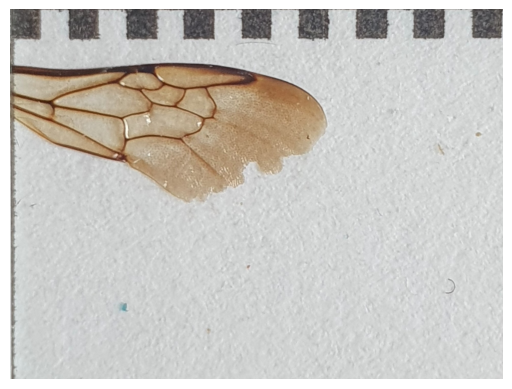

4.969740721841652
[276, 893, 32, 1266]


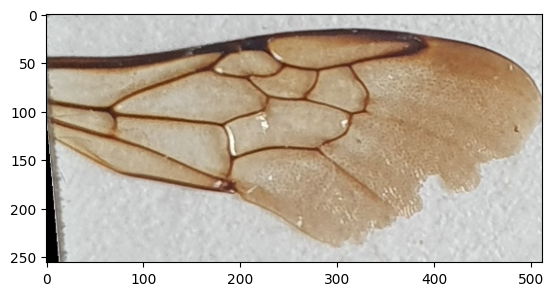

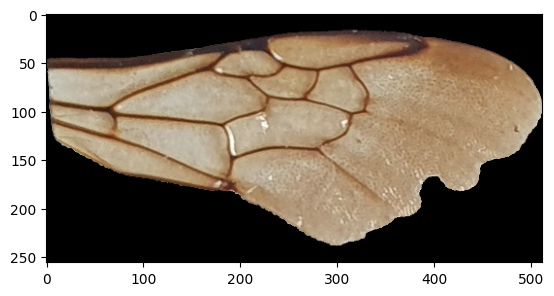

In [10]:
#opening and processing images
#run this cell if you want to test the above protocol "on the fly", or test it on specific images

wing_images_directory = "/home/gabriel/Documents/TR DIMA/data/Images_orga_cropping"

image_names = list_files(wing_images_directory)
test_name = "/home/gabriel/Documents/TR DIMA/data/Images_orga_cropping/Bombus_ruderarius/Ouvriere/ABAURA4902/ABAURA4902_S3.jpg"

images_test = image_names[900:905] #you can for instance take some images in your images folder

for dir in images_test:
    current_image = cv2.imread(dir)
    current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2RGB)

    current_crop,current_seg,angle,bbox = segment_and_crop(current_image)

    plt.imshow(current_image)
    plt.axis('off')
    plt.show()
    print(angle)
    print(bbox)
    plt.imshow(current_crop)
    plt.show()

    plt.imshow(current_seg)
    plt.show()

In [ ]:
#initialise data.json (uncomment if necessary) 

# initial_dict = {}

# wanted_path_for_file = "/home/gabriel/Documents/TR DIMA/data_clean/wing_segmentation_clean_outputs"

# with open(wanted_path_for_file+'/'+'status&transformations.json', 'w') as file:
#     json.dump(initial_dict, file)

In [ ]:
#cropping images and saving them into a specific folder

#directories

#directory for the images to process(images can be in subfolders)
wing_images_directory = "/home/gabriel/Documents/TR DIMA/data/Images_orga_cropping"

#directory where the processed images will go
crop_result_directory = "/home/gabriel/Documents/TR DIMA/data_clean/wing_segmentation_clean_outputs/cropped_wings"
seg_result_directory = "/home/gabriel/Documents/TR DIMA/data_clean/wing_segmentation_clean_outputs/segmented_wings"
status_file = "/home/gabriel/Documents/TR DIMA/data_clean/wing_segmentation_clean_outputs/status&transformations.json" #directory of the json file in which there are information about transformations and where to find initial image

list_file_names = list_files(wing_images_directory)
initial_len = len(list_file_names)

with open(status_file, 'r') as file:

    status = json.load(file)
    number_to_directory = status
    keys = list(status.keys())
    count = 0
    for index,name in enumerate(list_file_names[::-1]):
        if name in keys:
            list_file_names.pop(initial_len-index-1)
            count += 1

print(f'{count} files already trated, removing from list of files to treat')

time1 = int(time.time())

for index,dir in enumerate(list_file_names):
    i = index + count

    current_image = cv2.imread(dir)

    if current_image is None:
        print(f"Error : Image not loaded, directory = {dir}")

    else:
        current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2RGB) #to RGB
        current_crop,current_seg,angle,bbox = segment_and_crop(current_image)

        #saving
        imageio.imwrite(crop_result_directory + f'/{i}.png',current_crop)
        imageio.imwrite(seg_result_directory + f'/{i}.png',current_seg)

        number_to_directory[i] = dir

        with open(status_file, 'w') as file:
            json.dump(number_to_directory, file)

    if (index+1)%10 == 0:
        time2 = int(time.time())
        print(f"in progress : {(index+1)} images processed; {len(list_file_names) - (index+1)} remaining; time : {time2-time1} s; time per picture : {(time2-time1)/((index+1))} s")





0 files already trated, removing from list of files to treat
in progress : 10 images processed; 2915 remaining; time : 151 s; time per picture : 15.1 s
in progress : 20 images processed; 2905 remaining; time : 299 s; time per picture : 14.95 s
in progress : 30 images processed; 2895 remaining; time : 453 s; time per picture : 15.1 s
in progress : 40 images processed; 2885 remaining; time : 607 s; time per picture : 15.175 s
in progress : 50 images processed; 2875 remaining; time : 794 s; time per picture : 15.88 s
in progress : 60 images processed; 2865 remaining; time : 964 s; time per picture : 16.066666666666666 s
in progress : 70 images processed; 2855 remaining; time : 1084 s; time per picture : 15.485714285714286 s
in progress : 80 images processed; 2845 remaining; time : 1264 s; time per picture : 15.8 s
in progress : 90 images processed; 2835 remaining; time : 1432 s; time per picture : 15.911111111111111 s
in progress : 100 images processed; 2825 remaining; time : 1575 s; time

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
